# BooleAn Networks on the GPU (BANG) - demonstration

In [4]:
# pip install -i https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple/ bang-gpu==0.1.0a4
!pip install .

Processing /mnt/c/Users/mikolaj/Desktop/studia/bang
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for bang-gpu: filename=bang_gpu-0.1.0a4-py3-none-any.whl size=41102 sha256=d5736ba780b33658cdc1616e2dd637e66982be18e895bc2ef09cc132bc4891e0
  Stored in directory: /tmp/pip-ephem-wheel-cache-406n5hl0/wheels/cf/93/02/9541d5f8c1bccbadad93174011f478ca7b3220491698839593
Successfully built bang-gpu
  Attempting uninstall: bang-gpu
    Found existing installation: bang-gpu 0.1.0a4
    Uninstalling bang-gpu-0.1.0a4:
      Successfully uninstalled bang-gpu-0.1.0a4


## What is a (Probabilistic) Boolean Network?
Probabilistic Boolean Networks are mathematical structures consisting of a set of Boolean variables as well as one or more functions corresponding to each variable and computing its state based on current values of variables.

In the case of deterministic Boolean Networks, each variable has only one function which can depend on any other variable. In the case of Probabilistic Boolean Networks, each variable can have many functions, each of the functions having its associated probability of being chosen as the rule for the update.

Eventually, after a finite amount of time steps the states of these Networks stabilize into just a few constantly recurring values - the sets of these values are called attractors.

## Visualization of Boolean Networks

 The example on the left below shows a graph of the networks' nodes - if a node's value influenced another node (this means it's present in the node's function), then we draw an edge from the former to the latter.

 The example on the right shows a State Transition Diagram, which directly represent the evolution of the network in time. Given any state, we can trace where the network will end up by following all of its outgoing edges. In this particular example, we can see that there is a single attractor with states 000, 101 and 111.

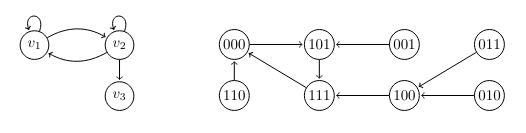

## What are Probabilistic Boolean Networks used for?
Probabilistic Boolean Networks in spite of a relatively simple structure allow to model behaviour of complex systems in discrete time series. One of the most often modelled objects are **Gene Regulatory Networks**, used for modelling evolution of cell in a time period. Nodes of Boolean Networks correspond well to the genes of a cell and attractors are a great representation of final stages of cell evolution.

The final stages could be stem cells or liver cells - knowledge of the attractors of the network can provide insight needed to turn one into the other by controlling which genes are active and which are not.


<div style="text-align: center;">
  <img src="notebook_files/img/complicated-gre.jpeg" alt="gre" width="600"/>
</div>

## Loading a network from a file

Probabilistic Boolean Networks can be represented in an *.sbml* format which is an extension of XML and a standard for representing biological models. Alternatively, we can import files in .*pbn* format which was used in previous software modelling PBNs.

We start by downloading a file which contains a simple PBN.

In [5]:
import requests

url = "https://raw.githubusercontent.com/pavozayac/bang/refs/heads/main/notebook_files/files/test2.pbn"

response = requests.get(url)
content = response.text

with open("example_network.pbn", "w") as file:
    file.write(content)

Now we can load Probabilistic Boolean Network from this file


In [6]:
import bang

pbn = bang.load_from_file("example_network.pbn", "assa")

## Simulation
Our Probabilistic Boolean Network is ready to be simulated on GPU!

We can run a simple test that concurrently runs five time steps on 512 networks at once and returns their final states.

In [7]:
pbn.set_states([[False for _ in range(3)] for _ in range(512)])
pbn.simple_steps(5)
print(pbn.get_last_state()[:10])
print(len(pbn.get_last_state()))

/mnt/c/Users/mikolaj/Desktop/studia/zpp/wslenv/lib/python3.12/site-packages/numba_cuda/numba/cuda/dispatcher.py:605: NumbaPerformanceWarning: Grid size 16 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


[[0]
 [0]
 [6]
 [2]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]]
512


As a result, we receive a sequence of 512 final states. Despite starting in the same initial state, the results differ across trajectories - this is because we are dealing with a Probabilistic Boolean Network. Additionally, there is a mechanism called perturbation, which can randomly switch node values - this can help explore more of the network.

## Decomposition of a Boolean Network into blocks

This is an example BN from the paper of dr Mizera, we will demonstrate library functionalities here.

There are six variables, $x_1,...,x_6$ with their boolean functions given as:

$x_1: \lnot(x_1 \land x_2)$

$x_2: x_1 \land (\lnot x_2)$

$x_3:  \lnot x_2$

$x_4: (x_2 \land x_3) \lor x_5$

$x_5: x_4 \lor x_5$

$x_6: \lnot x_3 \lor x_6$

In order to aid with efficient computation of attractors, a Boolean Network can be divided into *blocks*. A block is a concept defined on the dependencies between nodes, and it's closely related to the concept of a Strongly Connected Component. Every block is created by first dividing the network into SCCs, and then amending each SCC with the nodes which can influence it - that is, those that have in-edges to the SCC.

Below is a visual representation of the concept - SCCs on the left, and corresponding blocks on the right.
<div style="text-align: center;">
  <img src="notebook_files/img/bn-mizera.png" alt="bnmiz" width="600"/>
</div>

We will now showcase the functionality of decomposing the network into blocks on the exact Boolean Network shown in the image above.

In [12]:
import requests

url = "https://raw.githubusercontent.com/zpp20/bang/refs/heads/69-numba-version/examples/example.assa"

response = requests.get(url)
content = response.text

with open("example.assa", "w") as file2:
    file2.write(content)

In [13]:
pbn = bang.load_from_file("example.assa", "assa")
bang.get_blocks(pbn)

[[0, 1], [1, 2], [1, 2, 3, 4], [2, 5]]

These blocks directly correspond to the example pictured above, we have three two-element blocks and one four-element block.

We will now showcase the functionality of decomposing the network into blocks on the exact Boolean Network shown in the image above.

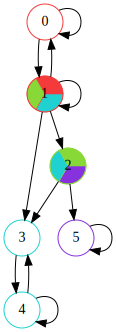

In [15]:
import requests

url = "https://raw.githubusercontent.com/zpp20/bang/refs/heads/69-numba-version/examples/example.assa"

response = requests.get(url)
content = response.text

with open("example.assa", "w") as file2:
    file2.write(content)

pbn_graph = bang.load_from_file("example.assa", "assa")
pbn_graph.block_graph()

## Attractor detection

We decompose Boolean Networks into smaller blocks with a subset of all nodes. Attractors computed on smaller blocks can be later combined to restore attractors of the original BN. In our library we implement algorithm from <br>

"*A new decomposition-based method for detecting attractors in synchronous Boolean networks.*" <br>
Qixia Yuan, Andrzej Mizera, Jun Pang, and Hongyang Qu. Science of Computer Programming, 180:18-35, 2019

We showcase finding attractors in three example BN's using our divide and conquer-like implementation

In [1]:
from bang.core.cuda.attractor_search import divide_and_counquer
from bang.core.PBN import PBN

SCP_PBN = PBN(
    3,
    [1, 1, 1],
    [2, 2, 1],
    [[True, True, True, False], [False, True, False, False], [True, False]],
    [[0, 1], [0, 1], [1]],
    [[1.0], [1.0], [1.0]],
    0.0,
    [3],
    update_type="synchronous"
)
SCP_PBN2 = PBN(
    5,
    [1, 1, 1, 1, 1],
    [2, 2, 1, 3, 2],
    [
        [True, True, True, False],
        [False, True, False, False],
        [True, False],
        [False, False, False, True, True, True, True, True],
        [False, True, True, True],
    ],
    [[0, 1], [0, 1], [1], [1, 2, 4], [3, 4]],
        [[1.0], [1.0], [1.0], [1.0], [1.0]],
    0.0,
    [3],
    update_type="synchronous"
)
SCP_PBN3 = PBN(
    6,
    [1, 1, 1, 1, 1, 1],
    [2, 2, 1, 3, 2, 2],
    [
        [True, True, True, False],
        [False, True, False, False],
        [True, False],
        [False, False, False, True, True, True, True, True],
        [False, True, True, True],
        [False, False, True, False],
    ],
    [[0, 1], [0, 1], [1], [1, 2, 4], [3, 4], [2, 5]],
    [[1.0], [1.0], [1.0], [1.0], [1.0], [1.0]],
    0.0,
    [3],
    update_type="synchronous"
)

print(divide_and_counquer(SCP_PBN))
print(divide_and_counquer(SCP_PBN2))
print(divide_and_counquer(SCP_PBN3))

/mnt/c/Users/mikolaj/Desktop/studia/zpp/wslenv/lib/python3.12/site-packages/numba_cuda/numba/cuda/dispatcher.py:605: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


ValueError: Two different states from the same state